<h1> AI CA5 REPORT </h1>
<h2>Atieh Armin - 810197648 </h2>
<p>The goal of this computer assignment is to get acquainted with Neural Networks.</p>
<h3>Preprocessing </h3>
<p>First, the examples of each class of train data are given.</p>

In [14]:
import numpy as np

N_CLASSES = 10


trainData = np.genfromtxt("trainData.csv", delimiter = ',')
trainLabels = np.genfromtxt("trainLabels.csv", delimiter = ',')

for i in range(N_CLASSES):
    for j in range(len(trainLabels)):
        if(trainLabels[j] == i):
            print('Label = ',i)
            print(trainData[j])
            break

Label =  0
[  0.   0.   0.   0.   0.   1.   0.   0.   0.   0.  41. 188. 103.  54.
  48.  43.  87. 168. 133.  16.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   1.   0.   0.   0.  49. 136. 219. 216. 228. 236. 255.
 255. 255. 255. 217. 215. 254. 231. 160.  45.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.  14. 176. 222. 224. 212. 203. 198. 196. 200.
 215. 204. 202. 201. 201. 201. 209. 218. 224. 164.   0.   0.   0.   0.
   0.   0.   0.   0.   0. 188. 219. 200. 198. 202. 198. 199. 199. 201.
 196. 198. 198. 200. 200. 200. 200. 201. 200. 225.  41.   0.   0.   0.
   0.   0.   0.   0.  51. 219. 199. 203. 203. 212. 238. 248. 250. 245.
 249. 246. 247. 252. 248. 235. 207. 203. 203. 222. 140.   0.   0.   0.
   0.   0.   0.   0. 116. 226. 206. 204. 207. 204. 101.  75.  47.  73.
  48.  50.  45.  51.  63. 113. 222. 202. 206. 220. 224.   0.   0.   0.
   0.   0.   0.   0. 200. 222. 209. 203. 215. 200.   0.  70.  98.   0.
 103.  59.  68.  71.  49.   0. 219. 206. 214. 210. 250.  38.   0. 

<p>Next step is to show the class distributions among train data and test data by bar charts. </p>

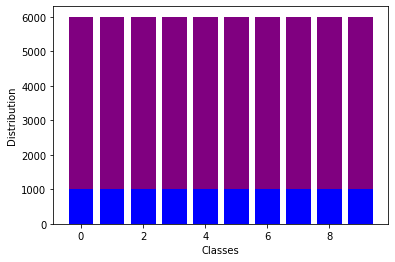

In [15]:
import pandas as pd
import matplotlib.pyplot as plt


trL = pd.DataFrame(trainLabels,dtype = int)
teL = pd.DataFrame(testLabels,dtype = int)

x = list(range(N_CLASSES))
plt.bar(x, trL.value_counts(), color="purple")
plt.bar(x, teL.value_counts(), color="blue")
plt.xlabel("Classes")
plt.ylabel("Distribution")
plt.show()

<p>Third step is to normalize data. Every number of the data is between 0 to 255 so to normalize them, they are divided by 256.

In [16]:
testData = np.genfromtxt("testData.csv", delimiter = ',')
testLabels = np.genfromtxt("testLabels.csv", delimiter = ',')

trainData = np.matrix(trainData, dtype = float)
testData = np.matrix(testData, dtype = float)

trainLabels = np.matrix(trainLabels, dtype = int).transpose()
testLabels = np.matrix(testLabels, dtype = int).transpose()

trainData = trainData/256
testData = testData/256


<h3>Implementing Neural Network </h3>
<p>Here is the implementation of the neural network.</p>

In [17]:
import random
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils import shuffle


<h3> Dataloader</h3>
<p>First data loader class is defined. This class gets data, labels, number of classes, batch size and shuffle and it basically load the data. </p>

In [18]:
class Dataloader:
    
    def __init__(self, data, labels, n_classes, batch_size=None, shuffle=False):

        assert len(data)==len(labels)
        self.__n_classes = n_classes
        self.__batch_size = batch_size
        self.__shuffle = shuffle
        self.__data = data
        self.__onehot_labels = self.__onehot(labels, self.__n_classes)
    
    def __onehot(self, labels, n_classes):
        # TODO: Implement
        onehot_encoder = OneHotEncoder(sparse=False)
        onehot_vectors = np.matrix(onehot_encoder.fit_transform(labels),dtype=float)
        return onehot_vectors
    
    def __shuffle_dataset(self):
        # TODO: Implement
        order = np.random.permutation(len(self.__data))
        self.__data = self.__data[order]
        self.__onehot_labels = self.__onehot_labels[order]
    
    def __iter__(self):
        if self.__shuffle:
            self.__shuffle_dataset()
            
        if self.__batch_size==None:
            yield (np.matrix(self.__data), np.matrix(self.__onehot_labels))
            return
            
        for idx in range(0, len(self.__data), self.__batch_size):
            yield (np.matrix(self.__data[idx:idx+self.__batch_size]), 
                   np.matrix(self.__onehot_labels[idx:idx+self.__batch_size]))

<h3> Activation Functions</h3>
<p>This is the implementation of several activation functions: Identical, Relu, Leaky Relu, Sigmoid and Softmax.</p>

In [19]:
class Identical:
    
    def __init__(self): pass
    
    def __val(self, matrix):
        identical_value = np.matrix(matrix, dtype=float)
        return identical_value

    def derivative(self, matrix):
        temp = np.matrix(matrix, dtype=float)
        identical_derivative = np.matrix(np.full(np.shape(temp), 1.))
        return identical_derivative
    
    def __call__(self, matrix):
        return self.__val(matrix)
    

class Relu:
    
    def __init__(self): pass
    
    def __relu(self, matrix):
        relu_value = np.matrix(matrix, dtype = float)
        relu_value[relu_value < 0] = 0 
        return relu_value

    def derivative(self, matrix):
        relu_derivative = np.matrix(matrix, dtype = float)
        relu_derivative[relu_derivative < 0] = 0
        relu_derivative[relu_derivative > 0] = 1
        return relu_derivative
    
    def __call__(self, matrix):
        return self.__relu(matrix)

    
class LeakyRelu:
    
    def __init__(self, negative_slope=0.01):
        self.negative_slope = negative_slope
    
    def __val(self, matrix):
        # TODO: Implement
        leaky_relu_value = np.matrix(matrix, dtype = float).copy()
        leaky_relu_value = np.where(leaky_relu_value < 0, self.negative_slope * leaky_relu_value, leaky_relu_value)
        return leaky_relu_value

    def derivative(self, matrix):
        # TODO: Implement
        leaky_relu_derivative = np.matrix(matrix, dtype = float).copy()
        leaky_relu_derivative[leaky_relu_derivative >= 0] = 1
        leaky_relu_derivative[leaky_relu_derivative < 0] = self.negative_slope
        return leaky_relu_derivative
    
    def __call__(self, matrix):
        return self.__val(matrix)

    
class Sigmoid:
    
    def __init__(self): pass

    def __val(self, matrix):
        # TODO: Implement
        sigmoid_value = np.matrix(1/(1+np.exp(-matrix)),dtype = float)
        return sigmoid_value

    def derivative(self, matrix):
        # TODO: Implement
        sigmoid_derivative = np.multiply(self.__val(matrix) ,(1-self.__val(matrix)))
        return sigmoid_derivative
    
    def __call__(self, matrix):
        return self.__val(matrix)


class Softmax:
    
    def __init__(self): pass

    def __val(self, matrix):
        shifted_matrix = matrix - matrix.max()
        expo = np.exp(shifted_matrix)
        expo_sum = np.sum(np.exp(shifted_matrix))
        softmax_value = expo / expo_sum
        return softmax_value

    def derivative(self, matrix):
        softmax_derivative = 1 / (1+np.exp(-matrix))
        return softmax_derivative
    
    def __call__(self, matrix):
        return self.__val(matrix)

<h3> Loss Function</h3>
<p> Loss function in this project is Cross Entropy. The activation function of the last layer is softmax to make the implementation and calculation of the derivation simpler.</p>

In [20]:
class CrossEntropy: #(with softmax)
    
    def __init__(self): pass

    def __val(self, true_val, expected_val):
        assert np.shape(true_val)==np.shape(expected_val)
        softmax = Softmax()
        softmax_out = np.matrix(true_val)
        for i in range(len(true_val)):
            softmax_out[i] = softmax(true_val[i])
        cross_entropy_value = np.matrix(- np.array(expected_val)* np.log(np.array(softmax_out)))
        return cross_entropy_value
        
    def derivative(self, true_val, expected_val):
        assert np.shape(true_val)==np.shape(expected_val)
        softmax = Softmax()
        softmax_out = np.matrix(true_val)
        for i in range(len(true_val)):
            softmax_out[i] = softmax(true_val[i])
        cross_entropy_derivative = softmax_out - expected_val
        return cross_entropy_derivative
    
    def __call__(self, true_val, expected_val):
        return self.__val(true_val, expected_val)

<h3> Layer</h3>
<p>In each layer, there is a forward function that stores last input, last input of the activation function of the layer, last output of the activation of the layer and the last calculated derivative of the activation of the layer. <br> In update weights function, the weights and biases of the layer will be updated.<br>Uniform weight and normal weight are the functions that calculate the initial weights of the layer randomly.</p>


In [21]:
class Layer:

    DEFAULT_LOW, DEFAULT_HIGH, DEFAULT_MEAN, DEFAULT_VAR = 0, 0.05, 0., 1.
  
    def __init__(self, input_size, output_size, 
                 activation=Identical(), initial_weight='uniform', **initializing_parameters):

        
        assert type(initial_weight)==str, 'Undefined activation function!'
        
        self.__weight_initializer_dict = {'uniform':self.__uniform_weight, 'normal':self.__normal_weight}
        
        self.__n_neurons = output_size
        weight_initializer = self.__weight_initializer_dict[initial_weight]
        self.__weight = weight_initializer(input_size, self.__n_neurons, **initializing_parameters)
        self.__bias = weight_initializer(1, self.__n_neurons, **initializing_parameters)
        self.__activation = activation
        
        self.__last_input = None
        self.__last_activation_input = None
        self.__last_activation_output = None
        self.__last_activation_derivative = None
        
    def forward(self, layer_input):
        assert np.ndim(layer_input)==2
        assert np.size(self.__weight,0) == np.size(layer_input,1)
        # TODO: Implement
        self.__last_input = layer_input
        self.__last_activation_input = np.matmul(self.__last_input,self.__weight) + self.__bias
        self.__last_activation_output = self.__activation(self.__last_activation_input)
        self.__last_activation_derivative = self.__activation.derivative(self.__last_activation_input)
        return self.__last_activation_output
    
    def update_weights(self, backprop_tensor, lr):
        assert np.ndim(backprop_tensor)==2
        assert np.size(backprop_tensor,0) == np.size(self.__last_activation_derivative,0)
        assert np.size(backprop_tensor,1) == self.__n_neurons
        # TODO: Implement
        grad_l_a = np.multiply(backprop_tensor , self.__last_activation_derivative)
        grad_l_w = np.matmul(self.__last_input.transpose(), grad_l_a)
        backprop_tensor = np.matmul(grad_l_a,self.__weight.transpose())
        self.__weight = self.__weight - lr*grad_l_w
        self.__bias = self.__bias - lr*grad_l_a.sum(axis=0)
        
        return backprop_tensor

    def __uniform_weight(self, dim1, dim2, **initializing_parameters):
        low, high = self.DEFAULT_LOW, self.DEFAULT_HIGH
        if 'low' in initializing_parameters.keys(): low = initializing_parameters['low']
        if 'high' in initializing_parameters.keys(): high = initializing_parameters['high']
        # TODO: Implement
        weights = np.random.uniform(low,high,size = (dim1,dim2))
        return weights

    def __normal_weight(self, dim1, dim2, **initializing_parameters):
        mean, var = self.DEFAULT_MEAN, self.DEFAULT_VAR
        if 'mean' in initializing_parameters.keys(): mean = initializing_parameters['mean']
        if 'var' in initializing_parameters.keys(): var = initializing_parameters['var']
        # TODO: Implement
        weights = np.random.normal(mean, np.sqrt(var), size = (dim1,dim2))
        return weights
    
    @property
    def n_neurons(self): return self.__n_neurons
    
    @property
    def weight(self): return self.__weight
    
    @property
    def bias(self): return self.__bias
    
    @property
    def activation(self): return self.__activation

<h3>Feed Forward Neural Network</h3>
<p>Here is the main class of the Feed Forward Neural Network. The training and back propagation of the Network accursed in this class.</p>

In [22]:
class FeedForwardNN:
    
    def __init__(self, input_shape):
        
        self.__input_shape = input_shape
        self.__output_shape = None
        
        self.__layers_list = []
        
        self.__lr = None
        self.__loss = None

        
    def add_layer(self, n_neurons, activation=Relu(), initial_weight='uniform', **initializing_parameters):
         
        assert type(n_neurons)==int, "Invalid number of neurons for the layer!"
        assert n_neurons>0, "Invalid number of neurons for the layer!"
        
        n_prev_neurons = self.__input_shape if len(self.__layers_list)==0 else self.__layers_list[-1].n_neurons
        new_layer = Layer(n_prev_neurons, n_neurons, activation, initial_weight, **initializing_parameters)
        self.__layers_list.append(new_layer)
        self.__output_shape = self.__layers_list[-1].n_neurons 
      
    
    def set_training_param(self, loss=CrossEntropy(), lr=1e-3):
        assert self.__layers_list, "Uncomplete model!"
        self.__loss = loss
        self.__lr = lr
    
    def output2D(self, inputloader):
        for x_input, y_input in inputloader:
            assert type(self.__output_shape) != None, "Model is not compiled!"
            layer_input = x_input
            i = 0
            for layer in self.__layers_list:
                network_output = layer.forward(layer_input)
                if(i == len(self.__layers_list)-2):
                    return network_output
                layer_input = network_output
                i+=1
        
    def forward(self, network_input):
        assert type(self.__output_shape) != None, "Model is not compiled!"
        # TODO: Implement
        layer_input = network_input
        for layer in self.__layers_list:
            network_output = layer.forward(layer_input)
            layer_input = network_output
        return network_output
    
    
    def fit(self, epochs, trainloader, testloader=None, print_results=True):
        
        assert type(self.__output_shape) != None, "Model is not compiled!"
        assert type(self.__lr) != None and type(self.__loss) != None, "Training paramenters are not set!"

        log = {"train_accuracy":[], "train_loss":[], "test_accuracy":[], "test_loss":[]}
        
        for epoch in range(1, epochs+1):
            
            if print_results: 
                print('Epoch {}:'.format(epoch)) 
                
            average_accuracy, average_loss = self.__train(trainloader)
            log['train_accuracy'].append(average_accuracy)
            log['train_loss'].append(average_loss)
            if print_results:
                print('\tTrain: Average Accuracy: {}\tAverage Loss: {}'.format(average_accuracy, average_loss))
            
            if type(testloader) != type(None):
                average_accuracy, average_loss = self.__test(testloader)
                log['test_accuracy'].append(average_accuracy)
                log['test_loss'].append(average_loss)
                if print_results:
                    print('\tTest: Average Accuracy: {}\tAverage Loss: {}'.format(average_accuracy, average_loss))
                    
        return log
    
    
    def __train(self, trainloader):
        bach_accuracies, batch_losses = [], []
        for x_train, y_train in trainloader:
            batch_accuracy, batch_loss = self.__train_on_batch(x_train, y_train)
            bach_accuracies.append(batch_accuracy)
            batch_losses.append(batch_loss)
        return np.mean(bach_accuracies), np.mean(batch_losses)
    
    
    def __test(self, testloader):
        bach_accuracies, batch_losses = [], []
        for x_test, y_test in testloader:
            batch_accuracy, batch_loss = self.__test_on_batch(x_test, y_test)
            bach_accuracies.append(batch_accuracy)
            batch_losses.append(batch_loss)
        return np.mean(bach_accuracies), np.mean(batch_losses)

    
    def __train_on_batch(self, x_batch, y_batch):
        # TODO: Implement
        batch_out = self.forward(x_batch)
        batch_losses = []
        labels = self.__get_labels(batch_out)
        batch_losses = self.__loss(labels, y_batch)
        batch_average_loss = sum(batch_losses)/len(x_batch)
        batch_accuracy = self.__compute_accuracy(labels,y_batch)
        self.__update_weights(batch_out, y_batch)
        return (batch_accuracy, batch_average_loss)
        
        
    def __test_on_batch(self, x_batch, y_batch):
        # TODO: Implement
        batch_out = self.forward(x_batch)
        batch_losses = []
        labels = self.__get_labels(batch_out)
        batch_losses = self.__loss(labels, y_batch)
        batch_average_loss = sum(batch_losses)/len(x_batch)
        batch_accuracy = self.__compute_accuracy(labels,y_batch)
        return (batch_accuracy, batch_average_loss)
    
    def __get_labels(self, outputs):
        # TODO: Implement
        labels = outputs.copy()
        for label in labels:
            ind = np.argmax(label)
            label.fill(0)
            label[0,ind] = 1.
        return labels
    
    
    def __compute_accuracy(self, output, expected_output):
        # TODO: Implement
        correct = 0
        for i in range(len(output)):
            label_out = np.argmax(output[i])
            label_expected = np.argmax(expected_output[i])
            if(label_out == label_expected): correct += 1
        accuracy = correct /len(expected_output)
        return accuracy
    
    
    def __update_weights(self, output, y_train):
        # TODO: Implement
        backprop_tensor = self.__loss.derivative(output,y_train)
        for layer in reversed(self.__layers_list):
            backprop_tensor = layer.update_weights(backprop_tensor, self.__lr)
        return

<h3>Data Classification </h3>
<h4>Step 1:</h4> <p>A neural network with at least two hidden layers and the hyper parameters shown below:</h4>
    Batch Size = 32<br>Number of Training Epochs = 30 <br> Activation Function = Relu<br> Weight Initialization = Uniform or Normal</p>

In [23]:

INPUT_SHAPE = 784
LEARNING_RATE = 0.001
EPOCHS = 30

train = trainData.copy()
trainL = trainLabels.copy()
test = testData.copy()
testL = testLabels.copy()

TRAINLOADER = Dataloader(train, trainL, 10, 32)
TESTLOADER = Dataloader(test, testL, 10, 32)

network = FeedForwardNN(INPUT_SHAPE)
network.add_layer(30, input_shape=INPUT_SHAPE, activation=Relu(), weight_initializer='uniform', low = 0.0001, high = 0.001)
network.add_layer(10, activation=Identical(), weight_initializer='uniform', low = 0.0001, high = 0.001)
network.set_training_param(loss=CrossEntropy(), lr=LEARNING_RATE)

log = network.fit(EPOCHS, TRAINLOADER, TESTLOADER)

Epoch 1:
	Train: Average Accuracy: 0.5918166666666667	Average Loss: 0.18693335050678078
	Test: Average Accuracy: 0.7652755591054313	Average Loss: 0.16958746126290436
Epoch 2:
	Train: Average Accuracy: 0.8061833333333334	Average Loss: 0.16549668384011412
	Test: Average Accuracy: 0.8120007987220448	Average Loss: 0.16491493730124301
Epoch 3:
	Train: Average Accuracy: 0.8342833333333334	Average Loss: 0.16268668384011412
	Test: Average Accuracy: 0.8243809904153354	Average Loss: 0.16367691813191396
Epoch 4:
	Train: Average Accuracy: 0.8450333333333333	Average Loss: 0.16161168384011412
	Test: Average Accuracy: 0.8311701277955271	Average Loss: 0.16299800439389478
Epoch 5:
	Train: Average Accuracy: 0.8518666666666667	Average Loss: 0.16092835050678078
	Test: Average Accuracy: 0.8373602236421726	Average Loss: 0.16237899480923024
Epoch 6:
	Train: Average Accuracy: 0.8568666666666667	Average Loss: 0.16042835050678078
	Test: Average Accuracy: 0.8422523961661342	Average Loss: 0.16188977755683406
Epoc

<h4>Step 2:</h4> 
<p>By multiplaying learning rate 10 times the train accuracy is better in the first few times and by multiplaying learning rate 1/10 times, the train accuracy is lower in the first few epochs. After several epochs the train accuracy of both cases are very close.</p>

In [24]:
LEARNING_RATE = 0.01

train = trainData.copy()
trainL = trainLabels.copy()
test = testData.copy()
testL = testLabels.copy()

TRAINLOADER = Dataloader(train, trainL, 10, 32)
TESTLOADER = Dataloader(test, testL, 10, 32)

network = FeedForwardNN(INPUT_SHAPE)
network.add_layer(30, input_shape=INPUT_SHAPE, activation=Relu(), weight_initializer='uniform', low = 0.0001, high = 0.001)
network.add_layer(10, activation=Identical(), weight_initializer='uniform', low = 0.0001, high = 0.001)
network.set_training_param(loss=CrossEntropy(), lr=LEARNING_RATE)

log = network.fit(EPOCHS, TRAINLOADER, TESTLOADER)

Epoch 1:
	Train: Average Accuracy: 0.58105	Average Loss: 0.18801001717344745
	Test: Average Accuracy: 0.586361821086262	Average Loss: 0.1874788350648213
Epoch 2:
	Train: Average Accuracy: 0.73295	Average Loss: 0.17282001717344747
	Test: Average Accuracy: 0.7207468051118211	Average Loss: 0.17404033666226537
Epoch 3:
	Train: Average Accuracy: 0.7938666666666667	Average Loss: 0.16672835050678078
	Test: Average Accuracy: 0.7928314696485623	Average Loss: 0.16683187020859128
Epoch 4:
	Train: Average Accuracy: 0.82355	Average Loss: 0.16376001717344746
	Test: Average Accuracy: 0.8230830670926518	Average Loss: 0.16380671046418233
Epoch 5:
	Train: Average Accuracy: 0.8347166666666667	Average Loss: 0.1626433505067808
	Test: Average Accuracy: 0.8267771565495208	Average Loss: 0.16343730151849542
Epoch 6:
	Train: Average Accuracy: 0.8419333333333333	Average Loss: 0.16192168384011413
	Test: Average Accuracy: 0.8184904153354633	Average Loss: 0.16426597563990117
Epoch 7:
	Train: Average Accuracy: 0.848

In [25]:
LEARNING_RATE = 0.0001

train = trainData.copy()
trainL = trainLabels.copy()
test = testData.copy()
testL = testLabels.copy()

TRAINLOADER = Dataloader(train, trainL, 10, 32)
TESTLOADER = Dataloader(test, testL, 10, 32)

network = FeedForwardNN(INPUT_SHAPE)
network.add_layer(30, input_shape=INPUT_SHAPE, activation=Relu(), weight_initializer='uniform', low = 0.0001, high = 0.001)
network.add_layer(10, activation=Identical(), weight_initializer='uniform', low = 0.0001, high = 0.001)
network.set_training_param(loss=CrossEntropy(), lr=LEARNING_RATE)

log = network.fit(EPOCHS, TRAINLOADER, TESTLOADER)

Epoch 1:
	Train: Average Accuracy: 0.14655	Average Loss: 0.23146001717344747
	Test: Average Accuracy: 0.2299321086261981	Average Loss: 0.22312180631082768
Epoch 2:
	Train: Average Accuracy: 0.4135	Average Loss: 0.20476501717344744
	Test: Average Accuracy: 0.4665535143769968	Average Loss: 0.1994596657357478
Epoch 3:
	Train: Average Accuracy: 0.5280333333333334	Average Loss: 0.19331168384011413
	Test: Average Accuracy: 0.575279552715655	Average Loss: 0.18858706190188199
Epoch 4:
	Train: Average Accuracy: 0.6517	Average Loss: 0.18094501717344746
	Test: Average Accuracy: 0.6810103833865815	Average Loss: 0.17801397883478934
Epoch 5:
	Train: Average Accuracy: 0.6992833333333334	Average Loss: 0.17618668384011413
	Test: Average Accuracy: 0.7074680511182109	Average Loss: 0.1753682120616264
Epoch 6:
	Train: Average Accuracy: 0.7261	Average Loss: 0.17350501717344746
	Test: Average Accuracy: 0.7299321086261981	Average Loss: 0.17312180631082769
Epoch 7:
	Train: Average Accuracy: 0.7487166666666667	

<h4>Step 3:</h4> 
<p>Here The Neural Network is designed with different activation functions.<br> The advantage of LeakyRelu over Relu is due top some Relu neurons essentially die for all inputs and remain inactive no matter what input is supplied. So here no gradient flows and if large number of dead neurons are there in a Neural Network it’s performance is affected. But leakyRelu extend the range of the relu by having a slope and not being zero at negative values. <br> Sigmoid function and it’s derivative is simple and helps in reducing time required for making models. But there is a major drawback of info loss due to the derivative having a short range. In another word, The output of sigmoid saturates for a large numbers. Thus, the gradient at these regions is almost zero.<br>Another drawback of the sigmoid function is that sigmoid outputs are not zero-centered, which is undesirable because it can indirectly introduce undesirable zig-zagging dynamics in the gradient updates for the weights.</p>
<p>From now on, leaky relu is the activation function</p>

In [26]:

LEARNING_RATE = 0.001

train = trainData.copy()
trainL = trainLabels.copy()
test = testData.copy()
testL = testLabels.copy()

TRAINLOADER = Dataloader(train, trainL, 10, 32)
TESTLOADER = Dataloader(test, testL, 10, 32)

network = FeedForwardNN(INPUT_SHAPE)
network.add_layer(30, input_shape=INPUT_SHAPE, activation=LeakyRelu(), weight_initializer='uniform', low = 0.0001, high = 0.001)
network.add_layer(10, activation=Identical(), weight_initializer='uniform', low = 0.0001, high = 0.001)
network.set_training_param(loss=CrossEntropy(), lr=LEARNING_RATE)

log = network.fit(EPOCHS, TRAINLOADER, TESTLOADER)

Epoch 1:
	Train: Average Accuracy: 0.5991666666666666	Average Loss: 0.1861983505067808
	Test: Average Accuracy: 0.7674720447284346	Average Loss: 0.16936781270060405
Epoch 2:
	Train: Average Accuracy: 0.8050666666666667	Average Loss: 0.1656083505067808
	Test: Average Accuracy: 0.8085063897763578	Average Loss: 0.16526437819581172
Epoch 3:
	Train: Average Accuracy: 0.8320166666666666	Average Loss: 0.1629133505067808
	Test: Average Accuracy: 0.8210862619808307	Average Loss: 0.16400639097536443
Epoch 4:
	Train: Average Accuracy: 0.8435666666666667	Average Loss: 0.1617583505067808
	Test: Average Accuracy: 0.8287739616613419	Average Loss: 0.16323762100731332
Epoch 5:
	Train: Average Accuracy: 0.8519166666666667	Average Loss: 0.1609233505067808
	Test: Average Accuracy: 0.8349640575079872	Average Loss: 0.16261861142264877
Epoch 6:
	Train: Average Accuracy: 0.8573666666666667	Average Loss: 0.1603783505067808
	Test: Average Accuracy: 0.8401557507987221	Average Loss: 0.1620994420935753
Epoch 7:
	T

In [27]:
LEARNING_RATE = 0.001

train = trainData.copy()
trainL = trainLabels.copy()
test = testData.copy()
testL = testLabels.copy()

TRAINLOADER = Dataloader(train, trainL, 10, 32)
TESTLOADER = Dataloader(test, testL, 10, 32)

network = FeedForwardNN(INPUT_SHAPE)
network.add_layer(30, input_shape=INPUT_SHAPE, activation=Sigmoid(), weight_initializer='uniform', low = 0.0001, high = 0.001)
network.add_layer(10, activation=Identical(), weight_initializer='uniform', low = 0.0001, high = 0.001)
network.set_training_param(loss=CrossEntropy(), lr=LEARNING_RATE)

log = network.fit(EPOCHS, TRAINLOADER, TESTLOADER)

Epoch 1:
	Train: Average Accuracy: 0.31908333333333333	Average Loss: 0.21420668384011413
	Test: Average Accuracy: 0.5842651757188498	Average Loss: 0.1876884996015625
Epoch 2:
	Train: Average Accuracy: 0.6548666666666667	Average Loss: 0.1806283505067808
	Test: Average Accuracy: 0.7009784345047924	Average Loss: 0.17601717372296827
Epoch 3:
	Train: Average Accuracy: 0.7307	Average Loss: 0.17304501717344747
	Test: Average Accuracy: 0.7431110223642172	Average Loss: 0.17180391493702576
Epoch 4:
	Train: Average Accuracy: 0.7775833333333333	Average Loss: 0.16835668384011412
	Test: Average Accuracy: 0.7836461661341853	Average Loss: 0.16775040056002896
Epoch 5:
	Train: Average Accuracy: 0.8092833333333334	Average Loss: 0.16518668384011412
	Test: Average Accuracy: 0.8071086261980831	Average Loss: 0.1654041545536392
Epoch 6:
	Train: Average Accuracy: 0.8250333333333333	Average Loss: 0.16361168384011412
	Test: Average Accuracy: 0.8187899361022364	Average Loss: 0.16423602356322384
Epoch 7:
	Train: A

<h4>Step 4:</h4> 
<p>Pass the entire dataset into the Neural Network at once is a little impossible when the data is too large.  So, to overcome this problem we need to divide the data into smaller sizes named Batch.<br>Batch size is one of the most important hyperparameters to tune in modern deep learning systems. Using a larger batch size to train the model as it allows computational speedups from the parallelism of GPUs, will lead to poor generalization. On the one extreme, using a batch equal to the entire dataset guarantees convergence to the global optima of the objective function. However, this is at the cost of slower, empirical convergence to that optima. On the other hand, using smaller batch sizes have been empirically shown to have faster convergence. But the downside of using a smaller batch size is that the model is not guaranteed to converge to the global optima.<br>
 The Neural Networks with batch size 16 and 128 are shown below. </p>
 <p>From now on, the batch size is 16.</p>

In [28]:
LEARNING_RATE = 0.001

train = trainData.copy()
trainL = trainLabels.copy()
test = testData.copy()
testL = testLabels.copy()

TRAINLOADER = Dataloader(train, trainL, 10, 16)
TESTLOADER = Dataloader(test, testL, 10, 16)

network = FeedForwardNN(INPUT_SHAPE)
network.add_layer(30, input_shape=INPUT_SHAPE, activation=LeakyRelu(), weight_initializer='uniform', low = 0.0001, high = 0.001)
network.add_layer(10, activation=Identical(), weight_initializer='uniform', low = 0.0001, high = 0.001)
network.set_training_param(loss=CrossEntropy(), lr=LEARNING_RATE)

log = network.fit(EPOCHS, TRAINLOADER, TESTLOADER)

Epoch 1:
	Train: Average Accuracy: 0.59205	Average Loss: 0.18691001717344746
	Test: Average Accuracy: 0.772	Average Loss: 0.16891501717344748
Epoch 2:
	Train: Average Accuracy: 0.8100333333333334	Average Loss: 0.16511168384011413
	Test: Average Accuracy: 0.8138	Average Loss: 0.1647350171734475
Epoch 3:
	Train: Average Accuracy: 0.8356666666666667	Average Loss: 0.1625483505067808
	Test: Average Accuracy: 0.8301	Average Loss: 0.1631050171734475
Epoch 4:
	Train: Average Accuracy: 0.8462333333333333	Average Loss: 0.16149168384011414
	Test: Average Accuracy: 0.8382	Average Loss: 0.1622950171734475
Epoch 5:
	Train: Average Accuracy: 0.85285	Average Loss: 0.16083001717344747
	Test: Average Accuracy: 0.8425	Average Loss: 0.16186501717344748
Epoch 6:
	Train: Average Accuracy: 0.8576166666666667	Average Loss: 0.1603533505067808
	Test: Average Accuracy: 0.8447	Average Loss: 0.16164501717344748
Epoch 7:
	Train: Average Accuracy: 0.8606333333333334	Average Loss: 0.16005168384011412
	Test: Average A

In [29]:
LEARNING_RATE = 0.001

train = trainData.copy()
trainL = trainLabels.copy()
test = testData.copy()
testL = testLabels.copy()

TRAINLOADER = Dataloader(train, trainL, 10, 128)
TESTLOADER = Dataloader(test, testL, 10, 128)

network = FeedForwardNN(INPUT_SHAPE)
network.add_layer(30, input_shape=INPUT_SHAPE, activation=LeakyRelu(), weight_initializer='uniform', low = 0.0001, high = 0.001)
network.add_layer(10, activation=Identical(), weight_initializer='uniform', low = 0.0001, high = 0.001)
network.set_training_param(loss=CrossEntropy(), lr=LEARNING_RATE)

log = network.fit(EPOCHS, TRAINLOADER, TESTLOADER)

Epoch 1:
	Train: Average Accuracy: 0.5723947228144989	Average Loss: 0.18887554489199757
	Test: Average Accuracy: 0.765625	Average Loss: 0.16955251717344746
Epoch 2:
	Train: Average Accuracy: 0.7983630952380952	Average Loss: 0.16627870764963795
	Test: Average Accuracy: 0.8201147151898734	Average Loss: 0.16410354565446011
Epoch 3:
	Train: Average Accuracy: 0.8302683013503909	Average Loss: 0.16308818703840838
	Test: Average Accuracy: 0.8314873417721519	Average Loss: 0.16296628299623228
Epoch 4:
	Train: Average Accuracy: 0.8424673507462687	Average Loss: 0.1618682820988206
	Test: Average Accuracy: 0.8407832278481012	Average Loss: 0.16203669438863733
Epoch 5:
	Train: Average Accuracy: 0.8499189321250888	Average Loss: 0.16112312396093859
	Test: Average Accuracy: 0.8446400316455697	Average Loss: 0.1616510140088905
Epoch 6:
	Train: Average Accuracy: 0.855527052238806	Average Loss: 0.16056231194956685
	Test: Average Accuracy: 0.849189082278481	Average Loss: 0.16119610894559935
Epoch 7:
	Train: A

<h4>Step 5:</h4> 
<p>We are using a limited dataset and to optimise the learning and the graph we are using Gradient Descent which is an iterative process. So, updating the weights with single pass or one epoch is not enough. As the number of epochs increases, more number of times the weight are changed in the neural network and the curve goes from underfitting to optimal to overfitting curve. Here is a neural network with 40 epochs. The aim is to see the overfitting curve.</p>

In [30]:
LEARNING_RATE = 0.001
EPOCHS = 40

train = trainData.copy()
trainL = trainLabels.copy()
test = testData.copy()
testL = testLabels.copy()

TRAINLOADER = Dataloader(train, trainL, 10, 16)
TESTLOADER = Dataloader(test, testL, 10, 16)

network = FeedForwardNN(INPUT_SHAPE)
network.add_layer(30, input_shape=INPUT_SHAPE, activation=LeakyRelu(), weight_initializer='uniform', low = 0.0001, high = 0.001)
network.add_layer(10, activation=Identical(), weight_initializer='uniform', low = 0.0001, high = 0.001)
network.set_training_param(loss=CrossEntropy(), lr=LEARNING_RATE)

log = network.fit(EPOCHS, TRAINLOADER, TESTLOADER)


Epoch 1:
	Train: Average Accuracy: 0.6062	Average Loss: 0.18549501717344746
	Test: Average Accuracy: 0.7797	Average Loss: 0.1681450171734475
Epoch 2:
	Train: Average Accuracy: 0.8108166666666666	Average Loss: 0.1650333505067808
	Test: Average Accuracy: 0.8127	Average Loss: 0.1648450171734475
Epoch 3:
	Train: Average Accuracy: 0.8346166666666667	Average Loss: 0.16265335050678079
	Test: Average Accuracy: 0.8252	Average Loss: 0.1635950171734475
Epoch 4:
	Train: Average Accuracy: 0.84515	Average Loss: 0.16160001717344746
	Test: Average Accuracy: 0.8355	Average Loss: 0.16256501717344748
Epoch 5:
	Train: Average Accuracy: 0.8517333333333333	Average Loss: 0.16094168384011412
	Test: Average Accuracy: 0.8396	Average Loss: 0.1621550171734475
Epoch 6:
	Train: Average Accuracy: 0.8565666666666667	Average Loss: 0.16045835050678078
	Test: Average Accuracy: 0.845	Average Loss: 0.16161501717344748
Epoch 7:
	Train: Average Accuracy: 0.8608166666666667	Average Loss: 0.1600333505067808
	Test: Average Acc

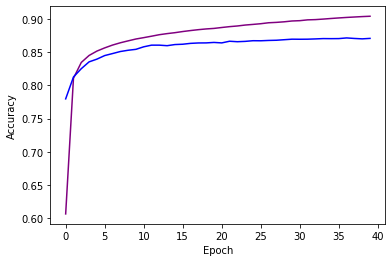

In [31]:
x = list(range(EPOCHS))
plt.plot(x, log['train_accuracy'], color="purple")
plt.plot(x, log['test_accuracy'], color="blue")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

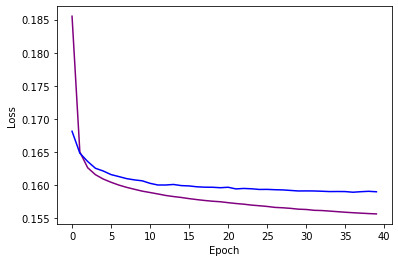

In [32]:
x = list(range(EPOCHS))
plt.plot(x, log['train_loss'], color="purple")
plt.plot(x, log['test_loss'], color="blue")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

<h3>Visualizing Data Reduced to two Dimensions</h3>
<p> The goal of this section is to reduce the demensions of the input to two and plot the chart of it.</p>

In [74]:
LEARNING_RATE = 0.001
EPOCHS = 8

train = trainData.copy()
trainL = trainLabels.copy()
test = testData.copy()
testL = testLabels.copy()

TRAINLOADER = Dataloader(train, trainL, 10, 16)
TESTLOADER = Dataloader(test, testL, 10, 16)

network = FeedForwardNN(INPUT_SHAPE)
network.add_layer(784, input_shape=INPUT_SHAPE, activation=LeakyRelu(), weight_initializer='uniform', low = 0.0001, high = 0.001)
#network.add_layer(100, input_shape=INPUT_SHAPE, activation=LeakyRelu(), weight_initializer='uniform', low = 0.0001, high = 0.001)
network.add_layer(2, input_shape=INPUT_SHAPE, activation=LeakyRelu(), weight_initializer='uniform', low = 0.0001, high = 0.001)
network.add_layer(10, activation=Identical(), weight_initializer='uniform')
network.set_training_param(loss=CrossEntropy(), lr=LEARNING_RATE)

log = network.fit(EPOCHS, TRAINLOADER, TESTLOADER)


Epoch 1:
	Train: Average Accuracy: 0.2346	Average Loss: 0.22265501717344746
	Test: Average Accuracy: 0.3191	Average Loss: 0.21420501717344748
Epoch 2:
	Train: Average Accuracy: 0.35413333333333336	Average Loss: 0.21070168384011412
	Test: Average Accuracy: 0.3823	Average Loss: 0.20788501717344748
Epoch 3:
	Train: Average Accuracy: 0.4040666666666667	Average Loss: 0.2057083505067808
	Test: Average Accuracy: 0.4701	Average Loss: 0.19910501717344747
Epoch 4:
	Train: Average Accuracy: 0.6028666666666667	Average Loss: 0.1858283505067808
	Test: Average Accuracy: 0.6979	Average Loss: 0.17632501717344748
Epoch 5:
	Train: Average Accuracy: 0.723	Average Loss: 0.17381501717344747
	Test: Average Accuracy: 0.7272	Average Loss: 0.1733950171734475
Epoch 6:
	Train: Average Accuracy: 0.7505833333333334	Average Loss: 0.17105668384011413
	Test: Average Accuracy: 0.7587	Average Loss: 0.17024501717344748
Epoch 7:
	Train: Average Accuracy: 0.7695	Average Loss: 0.16916501717344745
	Test: Average Accuracy: 0.

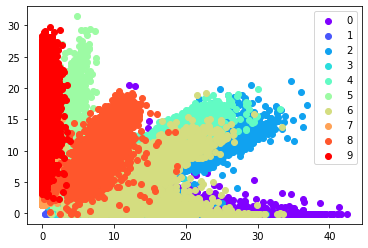

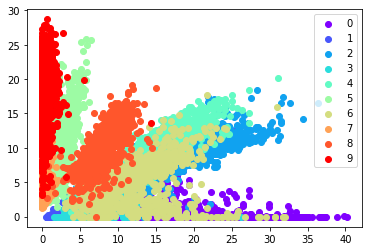

In [75]:
import matplotlib.cm as cm

train = trainData.copy()
trainL = trainLabels.copy()
test = testData.copy()
testL = testLabels.copy()

TRAINLOADER = Dataloader(train, trainL, 10)
TESTLOADER = Dataloader(test, testL, 10)

trainOut2D = network.output2D(TRAINLOADER)
testOut2D = network.output2D(TESTLOADER)


train_df = pd.DataFrame({'trainOut2D_x': trainOut2D[:,0].tolist(),'trainOut2D_y':trainOut2D[:,1].tolist() ,'Labels':trainL.flatten().tolist()[0]})
test_df = pd.DataFrame({'testOut2D_x': testOut2D[:,0].tolist(),'testOut2D_y':testOut2D[:,1].tolist() ,'Labels':testL.flatten().tolist()[0]})


colors = cm.rainbow(np.linspace(0, 1, N_CLASSES))
fig, ax = plt.subplots()
for i in range(N_CLASSES):
    x = train_df[train_df['Labels'] == i]['trainOut2D_x']
    y = train_df[train_df['Labels'] == i]['trainOut2D_y']
    plt.scatter(x, y, c = colors[i].reshape(1,-1), label=str(i))
    plt.legend()
plt.show()


for i in range(N_CLASSES):
    x = test_df[test_df['Labels'] == i]['testOut2D_x']
    y = test_df[test_df['Labels'] == i]['testOut2D_y']
    plt.scatter(x, y, c = colors[i].reshape(1,-1),label=str(i))
    plt.legend()
plt.show()

